['time', 'ax', 'ay', 'az', 'w', 'x', 'y', 'z', 'direct', 'yaw', 'pitch', 'roll']


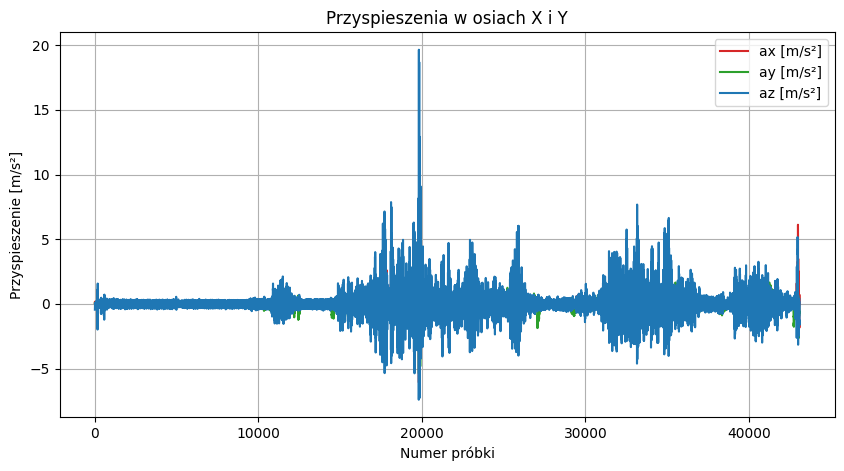

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


csv_file_1 = r"G:\projekt gropwy\22.10.2025\csv\bus\acc.csv"
csv_file_2 = r"G:\projekt gropwy\22.10.2025\csv\bus\orient.csv"
csv_file_3 = r"G:\projekt gropwy\22.10.2025\csv\bus\loc.csv"
# Spróbuj wczytać plik z przecinkiem jako separatorem i cudzysłowem jako quotechar
# Jeśli to nie zadziała, zmień sep na ';'
df1 = pd.read_csv(csv_file_1, sep=",", decimal=",", header=0)
df2 = pd.read_csv(csv_file_2, sep=",", decimal=",", header=0)
gps = pd.read_csv(csv_file_3, sep=",", decimal=",", header=0)
df = pd.merge(df1, df2, on='time', how='inner')
df.columns = df.columns.str.strip()
print(df.columns.tolist())


# Konwersja kolumn na odpowiednie typy danych
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df['ax'] = pd.to_numeric(df['ax'], errors='coerce')
df['ay'] = pd.to_numeric(df['ay'], errors='coerce')
df['az'] = pd.to_numeric(df['az'], errors='coerce')
df['yaw']   = pd.to_numeric(df['yaw'], errors='coerce')
df['pitch'] = pd.to_numeric(df['pitch'], errors='coerce')
df['roll']  = pd.to_numeric(df['roll'], errors='coerce')
df['direct'] = pd.to_numeric(df['direct'], errors='coerce')


df['ax'] = df['ax']
df['ay'] = df['ay']
df['az'] = df['az']


# === 7️⃣ Wykres przyspieszeń ax i ay ===
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['ax'], label='ax [m/s²]', color='tab:red')
plt.plot(df.index, df['ay'], label='ay [m/s²]', color='tab:green')
plt.plot(df.index, df['az'], label='az [m/s²]', color='tab:blue')
plt.xlabel('Numer próbki')
plt.ylabel('Przyspieszenie [m/s²]')
plt.title('Przyspieszenia w osiach X i Y')
plt.legend()
plt.grid(True)
plt.show()

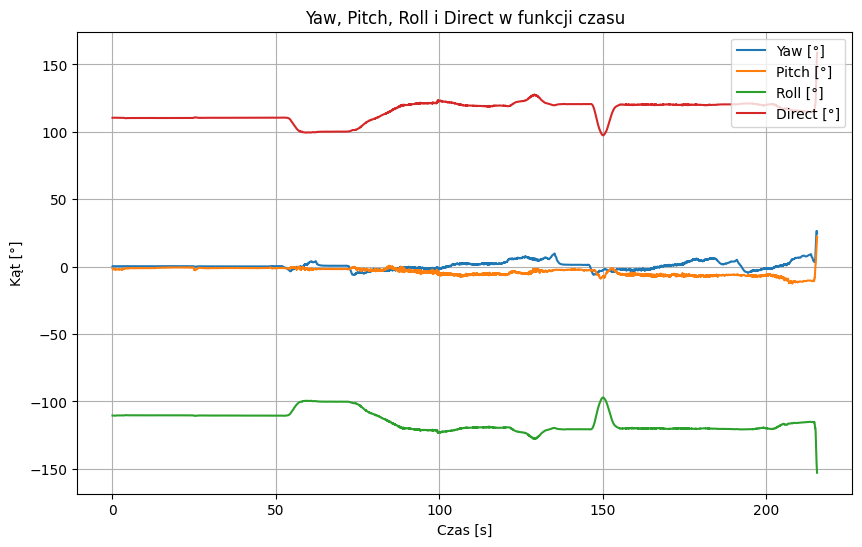

In [39]:

# Wykresy yaw, pitch, roll i direct w funkcji czasu
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['yaw'], label='Yaw [°]', color='tab:blue')
plt.plot(df['time'], df['pitch'], label='Pitch [°]', color='tab:orange')
plt.plot(df['time'], df['roll'], label='Roll [°]', color='tab:green')
plt.plot(df['time'], df['direct'], label='Direct [°]', color='tab:red')
plt.xlabel('Czas [s]')
plt.ylabel('Kąt [°]')
plt.title('Yaw, Pitch, Roll i Direct w funkcji czasu')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
a_north, a_east, a_up = [], [], []



for i in range(len(df)):

    psi= np.deg2rad(df.iloc[i]['yaw'])    # yaw
    theta=np.deg2rad(df.iloc[i]['pitch'])  # pitch
    phi= np.deg2rad(df.iloc[i]['roll'])   # roll
    ax = df.iloc[i]['ax']
    ay = df.iloc[i]['ay']
    az = df.iloc[i]['az']


    # macierz obrotu z układu telefonu do układu ziemi (NED)
    R = np.array([
        [np.cos(theta)*np.cos(psi),
         np.sin(phi)*np.sin(theta)*np.cos(psi) - np.cos(phi)*np.sin(psi),
         np.cos(phi)*np.sin(theta)*np.cos(psi) + np.sin(phi)*np.sin(psi)],

        [np.cos(theta)*np.sin(psi),
         np.sin(phi)*np.sin(theta)*np.sin(psi) + np.cos(phi)*np.cos(psi),
         np.cos(phi)*np.sin(theta)*np.sin(psi) - np.sin(phi)*np.cos(psi)],

        [-np.sin(theta),
         np.sin(phi)*np.cos(theta),
         np.cos(phi)*np.cos(theta)]
    ])

    # wektor przyspieszenia w układzie telefonu
    a_local = np.array([ax, ay, az])

    # przeliczenie na układ globalny (ziemski)
    a_global = R @ a_local

    # rozdzielone składowe
    a_east.append(a_global[0])
    a_north.append(a_global[1])
    a_up.append(a_global[2])

# dodanie kolumn do DataFrame
df['a_east'] = a_east
df['a_north'] = a_north
df['a_up'] = a_up

In [41]:
import numpy as np
from scipy.signal import butter, filtfilt

# 1️⃣ Oblicz częstotliwość próbkowania
dt = np.mean(np.diff(df['time']))
fs = 1 / dt
print(f"Częstotliwość próbkowania: {fs:.2f} Hz")

# 2️⃣ Definicja filtra Butterwortha
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# 3️⃣ Ustawienia filtra
cutoff = 1  # Hz
order = 3

# 4️⃣ Zastosuj filtr do każdej osi
df['a_east_f']  = butter_lowpass_filter(df['a_east'].values,  cutoff, fs, order)
df['a_north_f'] = butter_lowpass_filter(df['a_north'].values, cutoff, fs, order)
df['a_up_f']    = butter_lowpass_filter(df['a_up'].values,    cutoff, fs, order)

print("✅ Filtrowanie zakończone. Kolumny w df:", df.columns.tolist())


Częstotliwość próbkowania: 199.98 Hz
✅ Filtrowanie zakończone. Kolumny w df: ['time', 'ax', 'ay', 'az', 'w', 'x', 'y', 'z', 'direct', 'yaw', 'pitch', 'roll', 'a_east', 'a_north', 'a_up', 'a_east_f', 'a_north_f', 'a_up_f']


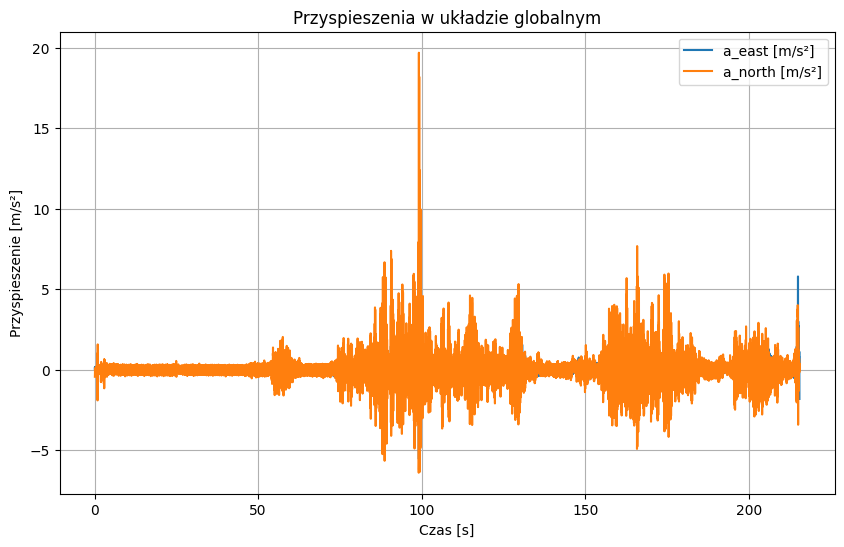

In [42]:

plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['a_east'], label='a_east [m/s²]', color='tab:blue')
plt.plot(df['time'], df['a_north'], label='a_north [m/s²]', color='tab:orange')

plt.xlabel('Czas [s]')
plt.ylabel('Przyspieszenie [m/s²]')
plt.title('Przyspieszenia w układzie globalnym')
plt.legend()
plt.grid(True)
plt.show()



In [43]:
east, north, up = sum(df['a_east']), sum(df['a_north']), sum(df['a_up'])
print(east, north, up)

df['a_east']  = df['a_east']  - df['a_east'].mean()
df['a_north'] = df['a_north'] - df['a_north'].mean()
df['a_up']    = df['a_up']    - df['a_up'].mean()

df['ax'] = df['ax'] - df['ax'].mean()
df['ay'] = df['ay'] - df['ay'].mean()
df['az'] = df['az'] - df['az'].mean()



In [44]:
import numpy as np

# upewnij się, że dane są uporządkowane rosnąco po czasie
df = df.sort_values('time').reset_index(drop=True)

import numpy as np

def integrate_trapz_adaptive(y, t):
    """
    Całkowanie trapezowe z nieregularnym krokiem czasowym.

    y – tablica wartości (np. przyspieszenie)
    t – tablica czasu (w sekundach)
    """
    y = np.asarray(y)
    t = np.asarray(t)

    v = np.zeros_like(y)
    for i in range(1, len(y)):
        dt = t[i] - t[i-1]         # różnica czasu
        v[i] = v[i-1] + 0.5 * (y[i] + y[i-1]) * dt
    return v


t = df['time'].values

a_east  = df['a_east'].values
a_north = df['a_north'].values
a_up    = df['a_up'].values

# Całkowanie 1: przyspieszenie → prędkość
v_east  = integrate_trapz_adaptive(a_east,  t)
v_north = integrate_trapz_adaptive(a_north, t)
v_up    = integrate_trapz_adaptive(a_up,    t)

df['v_east']  = v_east
df['v_north'] = v_north
df['v_up']    = v_up

# Całkowanie 2: prędkość → pozycja
x_east  = integrate_trapz_adaptive(v_east,  t)
y_north = integrate_trapz_adaptive(v_north, t)
z_up    = integrate_trapz_adaptive(v_up,    t)

df['x_east']  = x_east
df['y_north'] = y_north
df['z_up']    = z_up



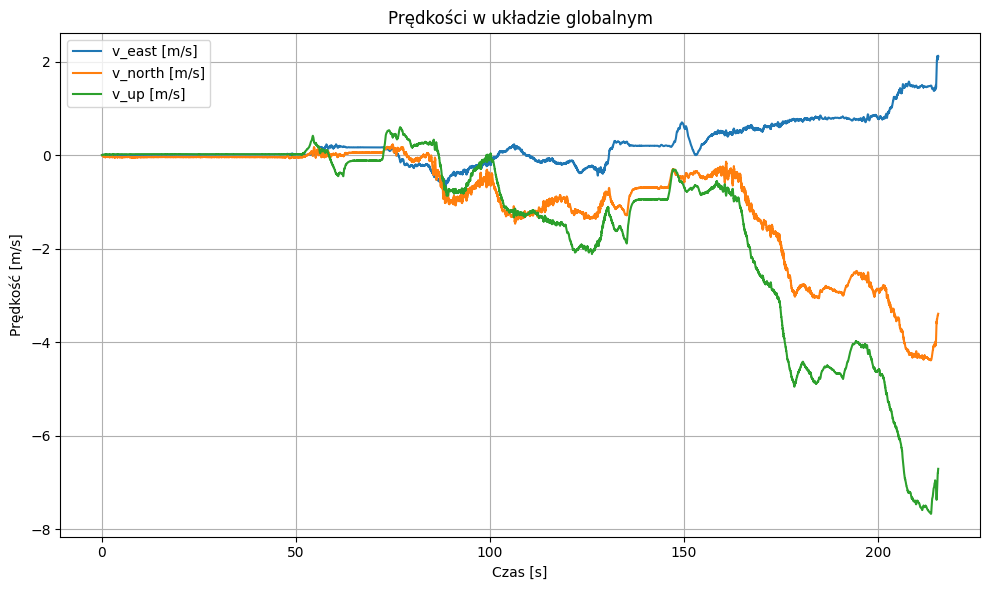

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df['time'], df['v_east'],  label='v_east [m/s]',  color='tab:blue')
plt.plot(df['time'], df['v_north'], label='v_north [m/s]', color='tab:orange')
plt.plot(df['time'], df['v_up'],    label='v_up [m/s]',    color='tab:green')

plt.xlabel('Czas [s]')
plt.ylabel('Prędkość [m/s]')
plt.title('Prędkości w układzie globalnym')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


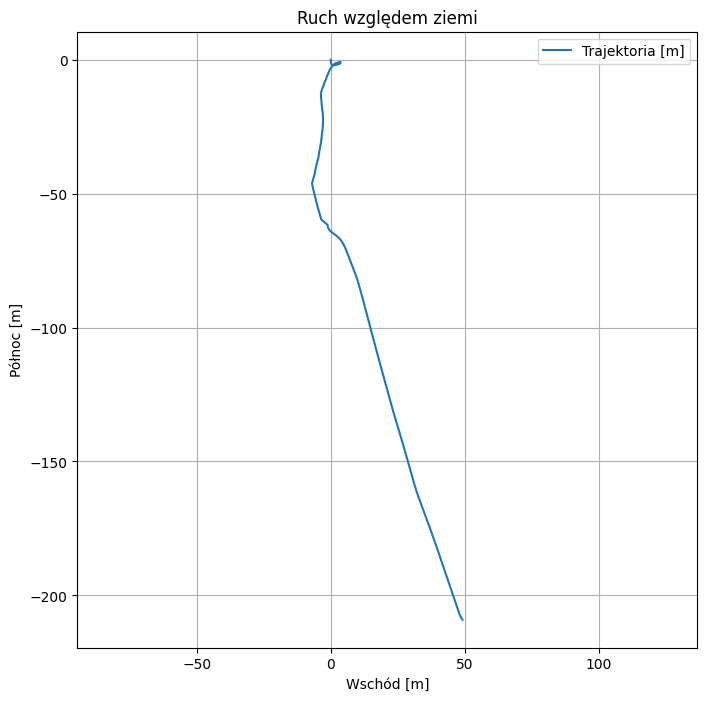

In [51]:
plt.figure(figsize=(8, 8))
plt.plot(df['x_east'], df['y_north'], label='Trajektoria [m]')
plt.xlabel('Wschód [m]')
plt.ylabel('Północ [m]')
plt.title('Ruch względem ziemi')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()
